# Chinese OCR

## 1. Import Libraries

In [1]:
import os
import sys
import shutil
import random
import time

from tqdm.notebook import tqdm

import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.container import Sequential
from torch.nn.utils.rnn import pad_sequence
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torchvision.models as models

Matplotlib is building the font cache; this may take a moment.


## 2. Creation of the Dataset

In [ ]:
# Creation of the DataFrame columns
columns = ["Character_ID", "Character", "Paths", "Directory", "File_Name"]
IDS = []
characters = []
paths = []
files_names = []
directories_names = []

# Initialisation of the ID
id = -1

# Initialisation of the valid characters
paths_dirs = ["CASIA-HWDB_Train", "CASIA-HWDB_Test"]
ROOT_PATH = "data/handwritten-chinese-character-hanzi-datasets/"
characters_file_path = "data/1000_most_frequent_chinese_characters.txt"

with open(characters_file_path, "r", encoding="utf-8") as file:
    valid_characters = [char.strip() for char in file if char.strip()]

# print(len(valid_characters))

# Iterating over the directories
for path_dir in paths_dirs:
    # Initialisation of the PATH
    PATH = f"{ROOT_PATH}{path_dir}/{path_dir[11:]}"
    
    for directory in tqdm(os.listdir(PATH)):
        if directory != ".DS_Store" and directory in valid_characters:
            id += 1
            # Iterating over the files
            for file in os.listdir(f"{PATH}/{directory}"):
                IDS.append(id)
                characters.append(directory)
                paths.append(f"{PATH}/{directory}/{file}")
                files_names.append(file)
                directories_names.append(path_dir[11:])

# Creation of the DataFrame
data = pd.DataFrame({
    columns[0]: IDS,
    columns[1]: characters,
    columns[2]: paths,
    columns[3]: directories_names,
    columns[4]: files_names
})

data.to_csv("data/data.csv", index=False)

In [ ]:
# Load the DataFrame
data = pd.read_csv("data/data.csv")

# Create the new directories
NEW_ROOT_PATH = "./data/NewData/"
os.makedirs(os.path.join(NEW_ROOT_PATH, "Train"), exist_ok=True)
os.makedirs(os.path.join(NEW_ROOT_PATH, "Test"), exist_ok=True)

# Copy the files to the new directories
for _, row in tqdm(data.iterrows(), total=len(data)):
    character = row["Character"]
    directory_type = row["Directory"]
    
    # Create the new subdirectory
    new_subdir_path = os.path.join(NEW_ROOT_PATH, directory_type, character)
    os.makedirs(new_subdir_path, exist_ok=True)
    
    # Define the source and destination paths
    src_path = row["Paths"]
    dest_path = os.path.join(new_subdir_path, row["File_Name"])
    
    # Copy the file
    shutil.copy(src_path, dest_path)

print("Files copied successfully!")

  0%|          | 0/71938 [00:00<?, ?it/s]

Les fichiers ont été copiés avec succès dans la nouvelle structure.


Display some information about the dataset (number of images and classes).

In [ ]:
print(f"There are {data.shape[0]} images in whole dataset.")
print(f"{len(data[data['Directory'] == 'Train'])} images in Train directory and {len(data[data['Directory'] == 'Test'])} in Test part.")
print(f"{round(np.array(data['Character_ID']).max() / 2)} characters (classes).")

There are 71938 images in whole dataset.
58088 images in Train directory and 13850 in Test part.
96 characters (classes).


In [ ]:
def count_of_each_character(directory: str):
    """
    Count of each character in the dataset.

    Parameters:
        directory (str): The directory name.
    """
    count_numbers = []
    classes = []

    j = 0
    PATH = f"./data/NewData/{directory}"
    for character in os.listdir(PATH):
        if character == ".DS_Store" or character not in valid_characters:
            continue
        
        classes.append(character)
        for image in os.listdir(os.path.join(PATH, character)):
            j += 1

        count_numbers.append(j)
        j = 0

    # Plot the distribution of the count of images
    fig = go.Figure(data = [go.Bar(x = classes, y = count_numbers, marker_color = "royalblue")])

    fig.update_layout(title = f"Distribution of count of Images in {directory} dataset", xaxis_title = "Characters", yaxis_title = "Count", legend_title = "Legend")
    fig.update_layout(barmode = "group", xaxis={'categoryorder' : 'total descending'}, xaxis_tickangle = 0)

    fig.show()

In [6]:
count_of_each_character("Train")

In [7]:
count_of_each_character("Test")

Chemin de l'image : ./data/NewData/Train/后/74.png
Image chargée avec PIL et convertie en tableau numpy.
Character: 后


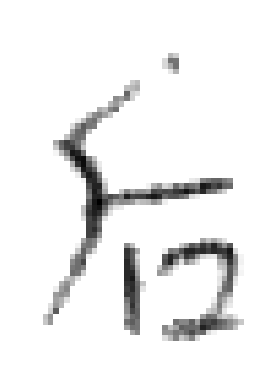

In [ ]:
def show_example_image(dataset: pd.Dataframe, part: str):
    """
    Show an example image from the dataset.

    Parameters:
        dataset (pd.DataFrame): The dataset.
        part (str): The part of the dataset (Train or Test
    """
    n = random.randint(50, 80)
    char = random.choice(dataset["Character"])
    
    PATH2image = f"./data/NewData/{part}/{char}/{n}.png"

    print(f"Path: {PATH2image}")

    # Load the image using PIL and convert it to a numpy array compatible with OpenCV
    try:
        example_image_pil = Image.open(PATH2image)
        example_image = np.array(example_image_pil)
        print("Image loaded with success.")
    except Exception as e:
        print(f"Error: Unable to load the image {PATH2image}. Details: {e}")
        return

    # Verify if the image is in grayscale and adjust if necessary
    if example_image.ndim == 2:
        # Alredy in grayscale
        print(f"Image in grayscale: {example_image.shape}")
    elif example_image.shape[2] == 3:
        # Convert to grayscale if it is in RGB
        example_image = cv2.cvtColor(example_image, cv2.COLOR_RGB2GRAY)
        print(f"Image converted to grayscale: {example_image.shape}")

    print(f"Character: {char}")
    plt.axis()
    plt.imshow(example_image, cmap="gray")
    plt.show()

show_example_image(data, "Train")

## 3. Image and dataset preparations

In [ ]:
def move_validation_files(folder: str):
    """
    Move the validation files to the validation folder.

    Parameters:
        folder (str): The folder name
    """
    # Create the parent directories if necessary
    validation_images_path = "./data/NewData/Validation_Images"
    if not os.path.exists(validation_images_path):
        os.makedirs(validation_images_path)
    
    # Create the folder for the specific character
    folder_path = os.path.join(validation_images_path, str(folder))
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)

    destination_path = os.path.join(validation_images_path, str(folder))
    folder_path_train = os.path.join("./data/NewData/Train", str(folder))

    try:
        files = os.listdir(folder_path_train)
        for i in range(min(75, len(files))):
            file = files[i]  
            shutil.move(os.path.join(folder_path_train, file), destination_path)
    except FileNotFoundError as e:
        print(f"Error : {e}")
    except Exception as e:
        print(f"Another error : {e}")

folders = data["Character"].unique()

for folder in folders:
    move_validation_files(folder)


In [ ]:
image_transformer = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize images to 96x96 pixels
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert to pytorch tensor
    transforms.RandomApply([
        transforms.RandomRotation(25),  # Random rotation of the image
        transforms.RandomAutocontrast()  # Ajust the contrast of the image
    ], p=0.6),  # Apply the transformations with a probability of 0.6
    transforms.Normalize([0.5], [0.5])  # Normalise the image
])

# Load the datasets
train_data = datasets.ImageFolder("./data/NewData/Train", transform = image_transformer)
test_data = datasets.ImageFolder("./data/NewData/Test", transform = image_transformer)
val_data = datasets.ImageFolder("./data/NewData/Validation_Images", transform = image_transformer)

In [ ]:
# Load the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 16, shuffle=False)

In [ ]:
for images, labels in train_loader:
    print(images.shape)  # Should be (batch_size, 1, 96, 96) if transformed correctly
    break

torch.Size([16, 1, 96, 96])


In [ ]:
# Check the loaders
print(f"Checking Train loader: {type(train_loader)}")
print(f"Checking Validation loader: {type(val_loader)}")
print(f"Checking Test loader: {type(test_loader)}")

Checking Train loader: <class 'torch.utils.data.dataloader.DataLoader'>
Checking Validation loader: <class 'torch.utils.data.dataloader.DataLoader'>
Checking Test loader: <class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
# Creation of the dictionary for the interpretation
nums = range(0, 7330)
labels = sorted([dir for dir in os.listdir("./data/NewData/Train")])

interpritation_dict = dict(zip(nums, labels))

# Save the dictionary
torch.save(interpritation_dict, "./model/interpritation_dict_96classes.pth")

interpritation_dict

{0: '一',
 1: '上',
 2: '下',
 3: '不',
 4: '与',
 5: '个',
 6: '中',
 7: '为',
 8: '主',
 9: '之',
 10: '也',
 11: '了',
 12: '事',
 13: '于',
 14: '人',
 15: '今',
 16: '他',
 17: '们',
 18: '会',
 19: '但',
 20: '你',
 21: '出',
 22: '分',
 23: '前',
 24: '力',
 25: '动',
 26: '发',
 27: '可',
 28: '同',
 29: '后',
 30: '向',
 31: '听',
 32: '和',
 33: '四',
 34: '国',
 35: '在',
 36: '地',
 37: '外',
 38: '大',
 39: '天',
 40: '女',
 41: '好',
 42: '如',
 43: '子',
 44: '学',
 45: '定',
 46: '对',
 47: '小',
 48: '就',
 49: '工',
 50: '常',
 51: '年',
 52: '应',
 53: '当',
 54: '得',
 55: '心',
 56: '想',
 57: '成',
 58: '我',
 59: '所',
 60: '手',
 61: '放',
 62: '日',
 63: '时',
 64: '明',
 65: '是',
 66: '最',
 67: '有',
 68: '本',
 69: '来',
 70: '水',
 71: '点',
 72: '然',
 73: '物',
 74: '现',
 75: '生',
 76: '的',
 77: '看',
 78: '知',
 79: '种',
 80: '第',
 81: '而',
 82: '自',
 83: '虽',
 84: '要',
 85: '说',
 86: '起',
 87: '过',
 88: '还',
 89: '这',
 90: '进',
 91: '道',
 92: '都',
 93: '里',
 94: '问',
 95: '面',
 96: '高'}

torch.Size([16, 1, 96, 96])
0) 了
1) 想
2) 放
3) 都
4) 自
5) 前
6) 他
7) 有
8) 四
9) 时


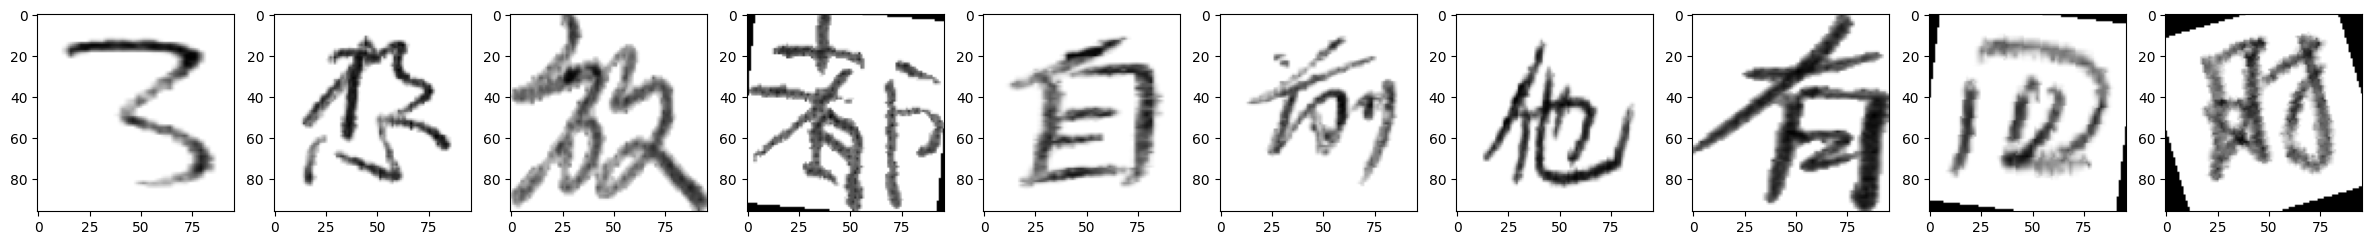

In [ ]:
# Visualize the images
dataiter = iter(train_loader) # Create an iterator
images, labels = next(dataiter) # Get the next batch of images
print(images.shape)

def loaders_viz(imgs: Tensors, labels: Tensors):
  """
  Loaders visualization.

  Parameters:
      imgs (Tensor): The images.
      labels (Tensor): The labels.
  """
  # Create a figure and a grid of subplots
  f, axes = plt.subplots(1, 10, figsize=(30,5))
  for i, axis in enumerate(axes):
      axes[i].imshow(np.squeeze(np.transpose(imgs[i][0].numpy(), (0, 1))), cmap = "gray") # Display the image
      print(f"{i}) {interpritation_dict[int(labels[i].numpy())]}") # Print the label

  plt.show()

loaders_viz(images, labels)

## 4. Model building & training

We will use CRNN (Convolutional Recurrent Neural Network) for this task. The model consists of a CNN for feature extraction and a RNN for sequence prediction. Why CRNN? Because it is a powerful model for text recognition in images.

### 4.1. CRNN Model

In [2]:
def CNN_backbone():
    """
    CNN backbone, the feature extractor.

    Returns:
        nn.Sequential: The CNN backbone.
    """
    relu = nn.ReLU()  # ReLU activation function to introduce non-linearity
    
    # Define convolutional layers with increasing filter sizes
    conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7, 7))  # 1st conv layer
    conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=(7, 7)) # 2nd conv layer
    conv3 = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=(5, 5)) # 3rd conv layer
    conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(5, 5)) # 4th conv layer
    conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3)) # 5th conv layer
    conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3)) # 6th conv layer
    
    pool = nn.MaxPool2d(kernel_size=(2, 2))  # Max pooling to reduce spatial dimensions
    
    conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3)) # 7th conv layer
    bn1 = nn.BatchNorm2d(256)  # Batch normalization for regularization and stability
    conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3)) # 8th conv layer
    
    # Arrange all layers in a list for sequential execution in the network
    blocks = [conv1, relu, conv2, relu, conv3, relu, conv4, relu, 
              conv5, relu, conv6, pool, relu, conv7, bn1, relu, conv8, relu]
              
    return nn.Sequential(*blocks)  # Return CNN backbone as a Sequential model


class CRNN(nn.Module):
    def __init__(self, number_class_symbols):
        super().__init__()
        self.feature_extractor = CNN_backbone()  # Initialize CNN backbone as the feature extractor
        
        # Average pooling to downsample the extracted features
        self.avg_pool1 = nn.AdaptiveAvgPool2d((100, 100))
        
        # Bi-directional LSTM to capture temporal dependencies in features
        self.bilstm = nn.LSTM(input_size=100, hidden_size=100, num_layers=1, 
                              batch_first=True, bidirectional=True)
                              
        # Second average pooling to further reduce feature dimensions
        self.avg_pool2 = nn.AdaptiveAvgPool2d((64, 64))
        
        self.flatten = nn.Flatten()  # Flatten layer to prepare features for fully connected layers
        
        # Fully connected layers for classification
        self.fc1 = nn.Linear(64 * 64, 32)  # First fully connected layer
        self.gelu = nn.GELU()  # GELU activation for non-linearity
        self.dropout = nn.Dropout(0.1)  # Dropout for regularization
        self.fc2 = nn.Linear(32, number_class_symbols)  # Final layer to output class probabilities

    def forward(self, x):
        # Pass input through the CNN feature extractor
        x = self.feature_extractor(x)
        
        # Reshape tensor for LSTM input
        b, c, h, w = x.size()  # Get batch, channel, height, and width
        x = x.view(b, c * h, w)  # Reshape to prepare for average pooling
        
        # Apply adaptive average pooling
        x = self.avg_pool1(x)
        
        # Prepare input for LSTM
        x = x.transpose(1, 2)  # Transpose to match LSTM input shape
        x, _ = self.bilstm(x)  # Pass through the Bi-LSTM layer
        
        # Apply second adaptive average pooling
        x = self.avg_pool2(x)
        
        # Flatten for the fully connected layers
        x = self.flatten(x)
        
        # Pass through fully connected layers with GELU and dropout
        x = torch.sigmoid(self.fc1(x))
        x = self.gelu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)  # Final layer
        
        return F.log_softmax(x, dim=1)  # Apply log softmax for class probability output

In [ ]:
# Check if the device is available
# if torch.backends.mps.is_available():
#     device = torch.device('mps')
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Device: {device}")

# Initialize the model
model = CRNN(number_class_symbols = len(data["Character"].unique()))
model.to(device)
model

Device: cuda


CRNN(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 96, kernel_size=(7, 7), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(96, 128, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): ReLU()
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (17): ReLU()
  )
  (avg_pool1): AdaptiveAvgPool2d(output_size=(100, 100))
  (bilstm): LSTM(100, 100, batch_first=True, bidirectional=True)
  (avg_pool2): AdaptiveAvgPool2

### 4.2. Training

In [ ]:
from tqdm.notebook import tqdm

# Initialize the optimizer with AdamW and set learning rate and weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00125, weight_decay=0.01)

# Set the loss function as CrossEntropy, suitable for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

def train(model: nn.Module, optimizer: torch.optim, loss_fn: torch.nn, train_dl: DataLoader, val_dl: DataLoader, save_path:str, epochs: int = 100, device: str = 'cpu') -> dict:
    """
    Train the model.

    Parameters:
        model (nn.Module): The model to train.
        optimizer (torch.optim): The optimizer to use for training.
        loss_fn (torch.nn): The loss function to use.
        train_dl (DataLoader): The training DataLoader.
        val_dl (DataLoader): The validation DataLoader.
        epochs (int): The number of epochs to train for.
        device (str): The device to train on.
        save_path (str): The path to save the best model.
    
    Returns:
        dict: The training history.
    """
    
    # Print training settings summary
    print('train() called: Model = %s, Optimizer = %s(lr=%f), Epochs = %d, Device = %s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    # Initialize history dictionary to store training and validation metrics
    history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
    best_train_acc = 0  # Track best training accuracy
    best_val_acc = 0    # Track best validation accuracy
    start_time_sec = time.time()  # Track total training time

    # Training loop over the specified number of epochs
    for epoch in tqdm(range(1, epochs + 1), desc='Epochs', unit='epoch'):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        num_train_correct = 0
        num_train_examples = 0
        epoch_start_time_sec = time.time()  # Track epoch time

        # Iterate over batches in training data
        for batch in tqdm(train_dl, desc='Training Batches', unit='batch', leave=False):
            optimizer.zero_grad()  # Reset gradients before backpropagation
            x = batch[0].to(device)  # Move input data to the specified device
            y = batch[1].to(device)  # Move target labels to the specified device
            yhat = model(x)  # Forward pass: get model predictions
            loss = loss_fn(yhat, y)  # Calculate loss between predictions and targets

            loss.backward()  # Backward pass to compute gradients
            optimizer.step()  # Update model weights based on gradients

            # Accumulate training loss and count correct predictions
            train_loss += loss.data.item() * x.size(0)  # Multiply by batch size to aggregate correctly
            num_train_correct += (torch.max(yhat, 1)[1] == y).sum().item()  # Count correct predictions
            num_train_examples += x.shape[0]  # Track number of training examples

        # Calculate epoch training accuracy and average loss
        train_acc = num_train_correct / num_train_examples
        train_loss = train_loss / len(train_dl.dataset)

        model.eval()  # Set model to evaluation mode for validation
        val_loss = 0.0
        num_val_correct = 0
        num_val_examples = 0

        # Iterate over batches in validation data
        for batch in val_dl:
            x = batch[0].to(device)
            y = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            # Accumulate validation loss and count correct predictions
            val_loss += loss.data.item() * x.size(0)
            num_val_correct += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        # Calculate epoch validation accuracy and average loss
        val_acc = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)
        
        epoch_end_time_sec = time.time()
        epoch_time_sec = epoch_end_time_sec - epoch_start_time_sec  # Calculate epoch duration

        # Print epoch summary of loss and accuracy
        print(f"Epoch {epoch}, time: {round(epoch_time_sec)} seconds. Train loss: {round(train_loss, 3)}, train accuracy: {round(train_acc, 3)}. Val loss: {round(val_loss, 3)}, val accuracy: {round(val_acc, 3)}")
        
        # Update best accuracies if the current ones are higher
        if train_acc > best_train_acc and val_acc > best_val_acc:
            best_train_acc = train_acc
            best_val_acc = val_acc
            best_epoch = epoch  # Track the epoch of the best accuracy
            torch.save(model.state_dict(), save_path)  # Save the best model's state dict

        # Record metrics in history for analysis and plotting
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)


    end_time_sec = time.time()
    total_time_sec = end_time_sec - start_time_sec  # Calculate total training time
    print("\n")
    print(f"Training Time: {round(total_time_sec)} seconds")
    print(f"The best epoch: {best_epoch}, Train Accuracy: {round(best_train_acc, 3)}, Validation Accuracy: {round(best_val_acc, 3)}")

    return history  # Return training history for further analysis

In [ ]:
history = train(model = model, optimizer = optimizer, loss_fn = loss_fn, epochs = 15, save_path = "best_model_96classes.pth",
                train_dl = train_loader, val_dl = val_loader, device = device)

train() called: Model = CRNN, Optimizer = AdamW(lr=0.001250), Epochs = 15, Device = cuda



Epochs:   0%|          | 0/15 [00:00<?, ?epoch/s]

Training Batches:   0%|          | 0/3304 [00:00<?, ?batch/s]

Epoch 1, time: 648 seconds. Train loss: 3.246, train accuracy: 0.227. Val loss: 2.443, val accuracy: 0.402


Training Batches:   0%|          | 0/3304 [00:00<?, ?batch/s]

Epoch 2, time: 674 seconds. Train loss: 2.001, train accuracy: 0.5. Val loss: 1.424, val accuracy: 0.67


Training Batches:   0%|          | 0/3304 [00:00<?, ?batch/s]

Epoch 3, time: 687 seconds. Train loss: 1.327, train accuracy: 0.668. Val loss: 0.997, val accuracy: 0.754


Training Batches:   0%|          | 0/3304 [00:00<?, ?batch/s]

Epoch 4, time: 699 seconds. Train loss: 0.987, train accuracy: 0.748. Val loss: 0.697, val accuracy: 0.832


Training Batches:   0%|          | 0/3304 [00:00<?, ?batch/s]

Epoch 5, time: 665 seconds. Train loss: 0.795, train accuracy: 0.792. Val loss: 0.576, val accuracy: 0.859


Training Batches:   0%|          | 0/3304 [00:00<?, ?batch/s]

Epoch 6, time: 673 seconds. Train loss: 0.667, train accuracy: 0.825. Val loss: 0.507, val accuracy: 0.872


Training Batches:   0%|          | 0/3304 [00:00<?, ?batch/s]

Epoch 7, time: 676 seconds. Train loss: 0.583, train accuracy: 0.845. Val loss: 0.449, val accuracy: 0.886


Training Batches:   0%|          | 0/3304 [00:00<?, ?batch/s]

Epoch 8, time: 696 seconds. Train loss: 0.518, train accuracy: 0.862. Val loss: 0.349, val accuracy: 0.915


Training Batches:   0%|          | 0/3304 [00:00<?, ?batch/s]

Epoch 9, time: 690 seconds. Train loss: 0.471, train accuracy: 0.873. Val loss: 0.31, val accuracy: 0.922


Training Batches:   0%|          | 0/3304 [00:00<?, ?batch/s]

Epoch 10, time: 701 seconds. Train loss: 0.435, train accuracy: 0.885. Val loss: 0.304, val accuracy: 0.924


Training Batches:   0%|          | 0/3304 [00:00<?, ?batch/s]

Epoch 11, time: 671 seconds. Train loss: 0.4, train accuracy: 0.891. Val loss: 0.268, val accuracy: 0.932


Training Batches:   0%|          | 0/3304 [00:00<?, ?batch/s]

Epoch 12, time: 680 seconds. Train loss: 0.371, train accuracy: 0.9. Val loss: 0.266, val accuracy: 0.932


Training Batches:   0%|          | 0/3304 [00:00<?, ?batch/s]

Epoch 13, time: 686 seconds. Train loss: 0.356, train accuracy: 0.904. Val loss: 0.275, val accuracy: 0.928


Training Batches:   0%|          | 0/3304 [00:00<?, ?batch/s]

Epoch 14, time: 680 seconds. Train loss: 0.33, train accuracy: 0.91. Val loss: 0.243, val accuracy: 0.935


Training Batches:   0%|          | 0/3304 [00:00<?, ?batch/s]

Epoch 15, time: 710 seconds. Train loss: 0.323, train accuracy: 0.912. Val loss: 0.21, val accuracy: 0.947


Training Time: 10237
The best epoch: 15, Train Accuracy: 0.912, Validation Accuracy: 0.947


The best epoch: 15, Train Accuracy: 0.912, Validation Accuracy: 0.947

#### 4.2.1. Train Summary

In [ ]:
from plotly.subplots import make_subplots

def train_summary(model_name: str, history: dict, epochs: list):
    """
    Plot the training and validation accuracy and loss over epochs.

    Parameters:
        model_name (str): The name of the model being trained.
        history (dict): Dictionary containing 'acc', 'val_acc', 'loss', and 'val_loss' lists.
        epochs (list): List of epoch numbers.
    """
    
    # Create a figure with 1 row and 2 columns for subplots: one for accuracy and one for loss
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Train/Val accuracy", "Train/Val loss"))
    
    # Plot the training accuracy over epochs on the first subplot
    fig.add_trace(go.Scatter(x=epochs, y=history["acc"],
                             mode="lines+markers",  # Plot lines with markers at each data point
                             name="Train Accuracy"),
                             row=1, col=1)  # Place in the first row, first column
    
    # Plot the validation accuracy over epochs on the first subplot
    fig.add_trace(go.Scatter(x=epochs, y=history["val_acc"],
                             mode="lines+markers",
                             name="Validation Accuracy"),
                             row=1, col=1)  # Place in the first row, first column

    # Plot the training loss over epochs on the second subplot
    fig.add_trace(go.Scatter(x=epochs, y=history["loss"],
                             mode="lines+markers",
                             name="Train Loss"),
                             row=1, col=2)  # Place in the first row, second column
    
    # Plot the validation loss over epochs on the second subplot
    fig.add_trace(go.Scatter(x=epochs, y=history["val_loss"],
                             mode="lines+markers",
                             name="Validation Loss"),
                             row=1, col=2)  # Place in the first row, second column    
    
    # Update the overall layout of the figure
    fig.update_layout(height=700, width=1200, title_text="Model training Summary", legend_title="Legend")
    
    # Set x-axis label for both subplots
    fig.update_xaxes(title_text="Epochs")
    
    # Set y-axis label specifically for accuracy in the first subplot
    fig.update_yaxes(title_text="Accuracy", row=1, col=1)
    
    # Set y-axis label specifically for loss in the second subplot
    fig.update_yaxes(title_text="Loss", row=1, col=2)

    # Display the figure
    fig.show()

In [22]:
train_summary("CRNN", history, list(range(1, 15 + 1)))

## 5. Model Evaluation and Conclusion

In [ ]:
folders = data["Character"].unique()  # Extract unique folder names based on character data

def testing_model(model, image_transformer, folders, interpretation_dict):
    """ 
    Test the model on a selection of images from different folders and display predictions.

    Parameters:
        model (torch.nn.Module): The trained model to be tested.
        image_transformer (function): The function to preprocess images before passing to the model.
        folders (list): List of folder names, each representing a character class.
        interpretation_dict (dict): Dictionary mapping model output indices to character names.
    """
    
    TEST_DIRECTORY_PATH = "./data/NewData/Test"  # Path to test dataset

    # Select 10 random folders to test on
    random_folders = random.choices(folders, k=10)
    
    # Loop through each randomly selected folder (character class)
    for folder in random_folders:
        # Loop through images in the current folder
        for image_name in os.listdir(os.path.join(TEST_DIRECTORY_PATH, folder)):
            # Load the image from the directory
            image = Image.open(os.path.join(TEST_DIRECTORY_PATH, folder) + "/" + image_name)
            
            # Transform the image to match model input format and move to the appropriate device
            image_transformed = image_transformer(image).to(device)
            
            # Reshape the image for model input and pass it through the model to get predictions
            model_output = model(image_transformed.reshape((1, 1, 96, image_transformed.shape[2])))
            
            # Get the index of the highest probability class from the model output
            prediction_num = np.argmax(model_output.data.cpu().numpy())
            
            # Map the index to the actual character using the interpretation dictionary
            prediction = interpretation_dict[prediction_num]
            
            # Display the prediction and the true label (folder name)
            print(f"Prediction: {prediction}. Truth: {folder}")
            
            # Display the original image
            plt.imshow(image, cmap="gray")
            plt.show()
            
            break  # Break after one image per folder for quicker testing

Prediction: 的. Truth: 的


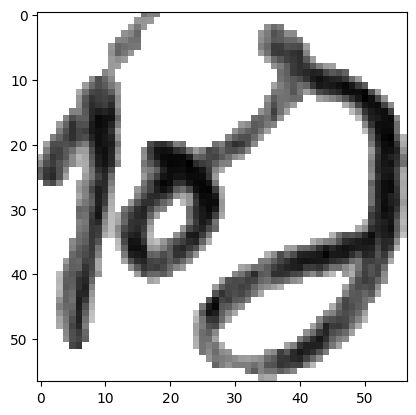

Prediction: 学. Truth: 学


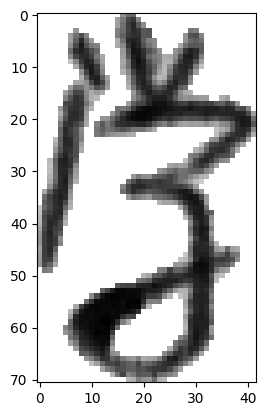

Prediction: 四. Truth: 四


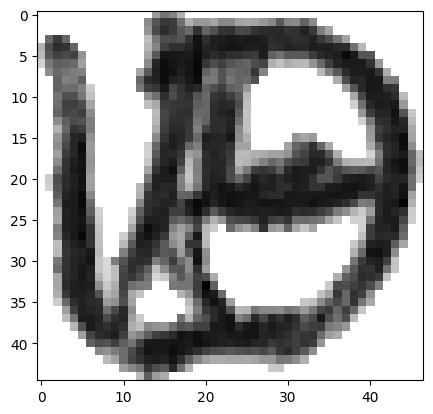

Prediction: 中. Truth: 中


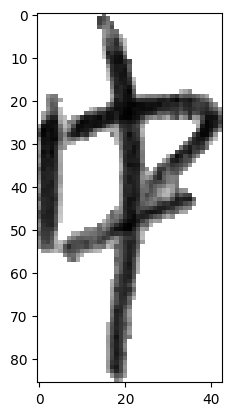

Prediction: 现. Truth: 现


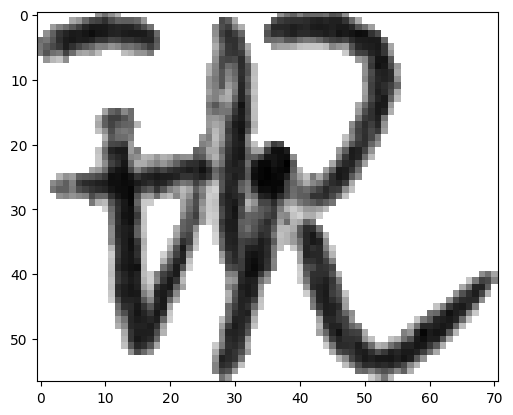

Prediction: 物. Truth: 物


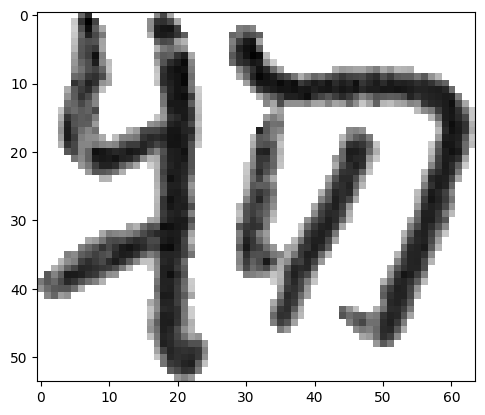

Prediction: 大. Truth: 大


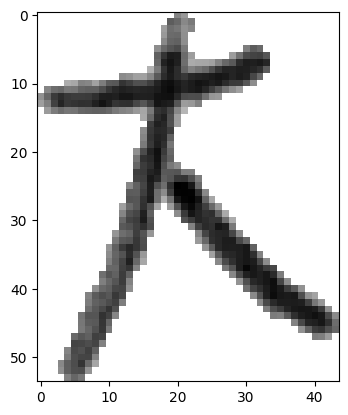

Prediction: 力. Truth: 力


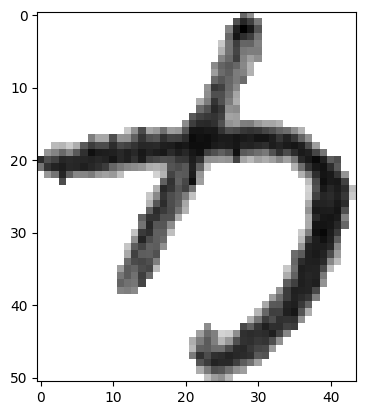

Prediction: 第. Truth: 第


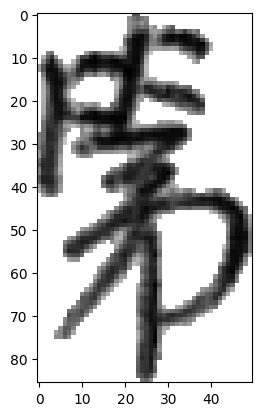

Prediction: 外. Truth: 外


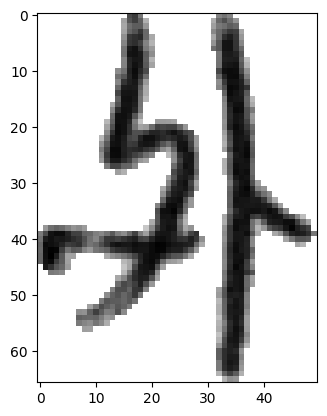

In [26]:
testing_model(model, image_transformer, folders, interpritation_dict)

## 6. Reutilization of the model on the Guilhem dataset

/var/folders/lw/14_89qr10g7cnpscxzk8kxch0000gn/T/ipykernel_24575/680607138.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model/bes

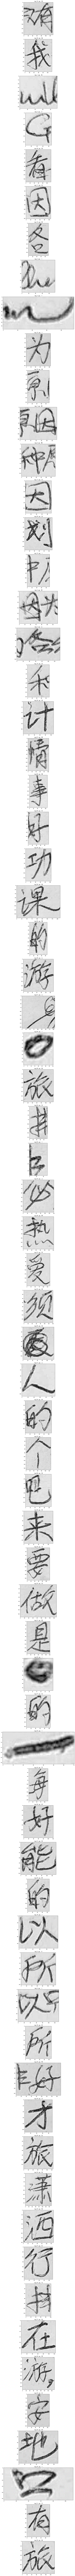

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
plt.rcParams['font.family'] = ['SimHei']  # Set font for displaying Chinese characters if needed

# Load the pre-trained model
data = pd.read_csv("data/data.csv")
model = CRNN(number_class_symbols = len(data["Character"].unique()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load('./model/best_model_96.pth', map_location=device))
model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates, etc.)

# Check if a GPU is available, and move the model to GPU if so
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

interpritation_dict = torch.load('./model/interpritation_dict_96classes.pth')

# Define transformations for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize image to 96x96 pixels
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale with one channel
    transforms.ToTensor(),  # Convert to PyTorch tensor (normalizes pixel values to [0,1])
    transforms.RandomApply([
        transforms.RandomRotation(25),  # Random rotation up to 25 degrees
        transforms.RandomAutocontrast()  # Randomly adjust contrast for variety
    ], p=0.6),  # Apply random transformations with a probability of 0.6
    transforms.Normalize([0.5], [0.5])  # Normalize grayscale values with mean and std dev of 0.5
])

# Folder containing unlabeled images
image_folder = './Char'
predictions = []

# Loop through each image file in the folder
for filename in os.listdir(image_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check if the file has an image extension
        img_path = os.path.join(image_folder, filename)
        
        # Load and transform the image
        image = Image.open(img_path).convert('L')  # Convert image to grayscale
        image_transformed = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to GPU
        
        # Make the prediction
        with torch.no_grad():  # Disable gradient calculation for efficiency
            output = model(image_transformed)  # Pass transformed image through the model
            predicted_class = torch.argmax(output, dim=1).item()  # Get the class with highest score
            predicted_char = interpritation_dict.get(predicted_class, '?')  # Use '?' for unmapped classes
            predictions.append((filename, predicted_char))

# Display the results
fig, axes = plt.subplots(nrows=len(predictions), ncols=1, figsize=(10, 5 * len(predictions)))

# Loop through predictions and display each image with its predicted label
for ax, (filename, predicted_char) in zip(axes, predictions):
    img_path = os.path.join(image_folder, filename)
    img = Image.open(img_path).convert('L')  # Reload the original image in grayscale
    ax.imshow(img, cmap='gray')  # Display the grayscale image
    ax.set_title(f"{filename}: {predicted_char}")  # Set title with filename and predicted character

plt.tight_layout()  # Adjust layout to fit all elements
plt.show()  # Display the figure